# Setup

In [86]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl

Load our data

In [87]:
# SPX historical market data from Yahoo Finance
# Source:  https://finance.yahoo.com/quote/%5ESPX/history?period1=-1325635200&period2=1710633600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
SPX_historical = pd.read_csv('SPX_historical.csv')
SPX_historical.rename({"Adj Close" : "AdjClose"}, axis = 1, inplace = True)
SPX_historical.head()

,Date,Open,High,Low,Close,AdjClose,Volume
0,1927-12-30,17.660000,17.660000,17.660000,17.660000,17.660000,0
1,1928-01-03,17.760000,17.760000,17.760000,17.760000,17.760000,0
2,1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,0
3,1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,0
4,1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,0


# Initial EDA

In [88]:
print("Object type: ", type(SPX_historical))
print("Dimensions: ", SPX_historical.shape)
print("Date range: ", SPX_historical["Date"].min(), "to", SPX_historical["Date"].max())
print("Index values range: ", SPX_historical["Low"].min(), "-", SPX_historical["High"].max())
print("Missing values: ", SPX_historical.isna().sum().sum())

Object type:  <class 'pandas.core.frame.DataFrame'>
Dimensions:  (24167, 7)
Date range:  1927-12-30 to 2024-03-15
Index values range:  4.4 - 5189.259766
Missing values:  0


We have nearly a century of data, however, the extreme values range, and changes in historic changes in economic structures and measurement methods leads me to believe we should investigate this data further. It also appears much of the data for the earliest dates contains the same values for Open, High, Low, and Close. While it might be possible to observe some kind of patterns in day-to-day change, I fear this total colinearity will weaken any model that is looking at *all* of these variables.

In [89]:
Same = SPX_historical.loc[SPX_historical["Open"] != SPX_historical["Close"]]
Same.head()

,Date,Open,High,Low,Close,AdjClose,Volume
8509,1962-01-02,0.0,71.959999,70.709999,70.959999,70.959999,3120000
8510,1962-01-03,0.0,71.480003,70.379997,71.129997,71.129997,3590000
8511,1962-01-04,0.0,71.620003,70.449997,70.639999,70.639999,4450000
8512,1962-01-05,0.0,70.839996,69.349998,69.660004,69.660004,4630000
8513,1962-01-08,0.0,69.839996,68.169998,69.120003,69.120003,4620000


Further investigation reveals that different High, Low, Open, and Close values were not recorded for years prior to 1961. I also want to investigate 'Open' values.

In [90]:
OpenZero = SPX_historical.loc[SPX_historical["Open"] == 0.0]
OpenZero.head()

,Date,Open,High,Low,Close,AdjClose,Volume
8509,1962-01-02,0.0,71.959999,70.709999,70.959999,70.959999,3120000
8510,1962-01-03,0.0,71.480003,70.379997,71.129997,71.129997,3590000
8511,1962-01-04,0.0,71.620003,70.449997,70.639999,70.639999,4450000
8512,1962-01-05,0.0,70.839996,69.349998,69.660004,69.660004,4630000
8513,1962-01-08,0.0,69.839996,68.169998,69.120003,69.120003,4620000


"Open" values are consistently zero from 1962 through 1982. Given all of the discrepancies above *and* the beginning of financialization in the 1980s, which contributed to significant changes in the ways the market might behave, I opt to remove all rows prior to 1983.

In [91]:
SPX_historical = SPX_historical.iloc[13602:].reset_index(drop=True)
SPX_historical.head()

,Date,Open,High,Low,Close,AdjClose,Volume
0,1982-04-20,115.800003,117.139999,114.830002,115.440002,115.440002,54610000
1,1982-04-21,115.480003,115.870003,115.300003,115.720001,115.720001,57820000
2,1982-04-22,115.720001,117.250000,115.720001,117.190002,117.190002,64470000
3,1982-04-23,118.019997,118.639999,117.190002,118.639999,118.639999,71840000
4,1982-04-26,118.940002,119.330002,118.250000,119.260002,119.260002,60500000


Next, I generate a plot to visualize Adjusted Close data over the remaining dataset.

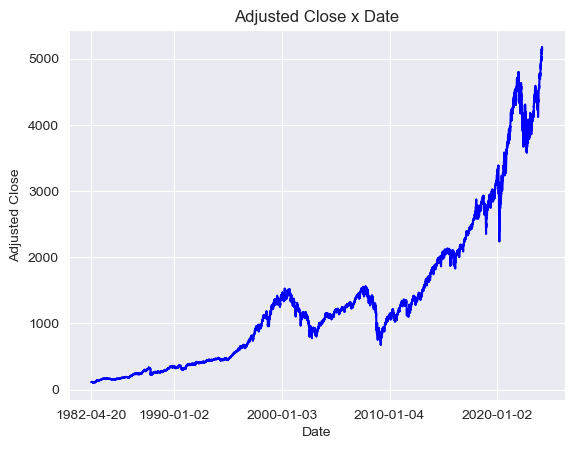

In [92]:
X = SPX_historical["Date"]
Y = SPX_historical["AdjClose"]
plt.figure()
plt.plot(X, Y, marker='', color='blue')
plt.title('Adjusted Close x Date')
plt.xticks([0,1948,4476,6991,9507])
plt.xlabel('Date')
plt.ylabel('Adjusted Close')
plt.grid(True)
plt.show()

# Imputation & feature creation

I start by creating a day average variable. This information is sometimes used for market prediction, and I aim to experiment incorporating it into my model.

In [93]:
SPX_historical.loc[:,"DayAvg"] = (SPX_historical["High"] + SPX_historical["Low"])/2
SPX_historical["DayAvg"].head()

0    115.985000
1    115.585003
2    116.485000
3    117.915001
4    118.790001
Name: DayAvg, dtype: float64

Here, I create lag-terms for all of my features.

In [94]:
# "Open" lags
SPX_historical["OpenLag1"] = SPX_historical["Open"].shift(1)
SPX_historical["OpenLag2"] = SPX_historical["Open"].shift(2)
SPX_historical["OpenLag3"] = SPX_historical["Open"].shift(3)
SPX_historical["OpenLag4"] = SPX_historical["Open"].shift(4)
SPX_historical["OpenLag5"] = SPX_historical["Open"].shift(5)
SPX_historical["OpenLag6"] = SPX_historical["Open"].shift(6)
SPX_historical["OpenLag7"] = SPX_historical["Open"].shift(7)
# "High" lags
SPX_historical["HighLag1"] = SPX_historical["High"].shift(1)
SPX_historical["HighLag2"] = SPX_historical["High"].shift(2)
SPX_historical["HighLag3"] = SPX_historical["High"].shift(3)
SPX_historical["HighLag4"] = SPX_historical["High"].shift(4)
SPX_historical["HighLag5"] = SPX_historical["High"].shift(5)
SPX_historical["HighLag6"] = SPX_historical["High"].shift(6)
SPX_historical["HighLag7"] = SPX_historical["High"].shift(7)
# "Low" lags
SPX_historical["LowLag1"] = SPX_historical["Low"].shift(1)
SPX_historical["LowLag2"] = SPX_historical["Low"].shift(2)
SPX_historical["LowLag3"] = SPX_historical["Low"].shift(3)
SPX_historical["LowLag4"] = SPX_historical["Low"].shift(4)
SPX_historical["LowLag5"] = SPX_historical["Low"].shift(5)
SPX_historical["LowLag6"] = SPX_historical["Low"].shift(6)
SPX_historical["LowLag7"] = SPX_historical["Low"].shift(7)
# "Close" lags
SPX_historical["CloseLag1"] = SPX_historical["Close"].shift(1)
SPX_historical["CloseLag2"] = SPX_historical["Close"].shift(2)
SPX_historical["CloseLag3"] = SPX_historical["Close"].shift(3)
SPX_historical["CloseLag4"] = SPX_historical["Close"].shift(4)
SPX_historical["CloseLag5"] = SPX_historical["Close"].shift(5)
SPX_historical["CloseLag6"] = SPX_historical["Close"].shift(6)
SPX_historical["CloseLag7"] = SPX_historical["Close"].shift(7)
# "Adj Close" lags
SPX_historical["AdjCloseLag1"] = SPX_historical["AdjClose"].shift(1)
SPX_historical["AdjCloseLag2"] = SPX_historical["AdjClose"].shift(2)
SPX_historical["AdjCloseLag3"] = SPX_historical["AdjClose"].shift(3)
SPX_historical["AdjCloseLag4"] = SPX_historical["AdjClose"].shift(4)
SPX_historical["AdjCloseLag5"] = SPX_historical["AdjClose"].shift(5)
SPX_historical["AdjCloseLag6"] = SPX_historical["AdjClose"].shift(6)
SPX_historical["AdjCloseLag7"] = SPX_historical["AdjClose"].shift(7)
# "Volume" lags
SPX_historical["VolumeLag1"] = SPX_historical["Volume"].shift(1)
SPX_historical["VolumeLag2"] = SPX_historical["Volume"].shift(2)
SPX_historical["VolumeLag3"] = SPX_historical["Volume"].shift(3)
SPX_historical["VolumeLag4"] = SPX_historical["Volume"].shift(4)
SPX_historical["VolumeLag5"] = SPX_historical["Volume"].shift(5)
SPX_historical["VolumeLag6"] = SPX_historical["Volume"].shift(6)
SPX_historical["VolumeLag7"] = SPX_historical["Volume"].shift(7)
# "DayAvg" lags
SPX_historical["DayAvgLag1"] = SPX_historical["DayAvg"].shift(1)
SPX_historical["DayAvgLag2"] = SPX_historical["DayAvg"].shift(2)
SPX_historical["DayAvgLag3"] = SPX_historical["DayAvg"].shift(3)
SPX_historical["DayAvgLag4"] = SPX_historical["DayAvg"].shift(4)
SPX_historical["DayAvgLag5"] = SPX_historical["DayAvg"].shift(5)
SPX_historical["DayAvgLag6"] = SPX_historical["DayAvg"].shift(6)
SPX_historical["DayAvgLag7"] = SPX_historical["DayAvg"].shift(7)
# Check that my features have been correctly created
SPX_historical.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume', 'DayAvg',
       'OpenLag1', 'OpenLag2', 'OpenLag3', 'OpenLag4', 'OpenLag5', 'OpenLag6',
       'OpenLag7', 'HighLag1', 'HighLag2', 'HighLag3', 'HighLag4', 'HighLag5',
       'HighLag6', 'HighLag7', 'LowLag1', 'LowLag2', 'LowLag3', 'LowLag4',
       'LowLag5', 'LowLag6', 'LowLag7', 'CloseLag1', 'CloseLag2', 'CloseLag3',
       'CloseLag4', 'CloseLag5', 'CloseLag6', 'CloseLag7', 'AdjCloseLag1',
       'AdjCloseLag2', 'AdjCloseLag3', 'AdjCloseLag4', 'AdjCloseLag5',
       'AdjCloseLag6', 'AdjCloseLag7', 'VolumeLag1', 'VolumeLag2',
       'VolumeLag3', 'VolumeLag4', 'VolumeLag5', 'VolumeLag6', 'VolumeLag7',
       'DayAvgLag1', 'DayAvgLag2', 'DayAvgLag3', 'DayAvgLag4', 'DayAvgLag5',
       'DayAvgLag6', 'DayAvgLag7'],
      dtype='object')

In [95]:
# Clip the first 7 rows to remove NAs in lag features
SPX_historical = SPX_historical.iloc[7:].reset_index(drop=True)
SPX_historical.head()

,Date,Open,High,Low,Close,AdjClose,Volume,DayAvg,OpenLag1,OpenLag2,...,VolumeLag5,VolumeLag6,VolumeLag7,DayAvgLag1,DayAvgLag2,DayAvgLag3,DayAvgLag4,DayAvgLag5,DayAvgLag6,DayAvgLag7
0,1982-04-29,116.400002,117.239998,116.110001,116.139999,116.139999,51330000,116.674999,117.830002,119.070000,...,64470000.0,57820000.0,54610000.0,117.495002,118.495002,118.790001,117.915001,116.485000,115.585003,115.985000
1,1982-04-30,116.209999,116.779999,116.070000,116.440002,116.440002,48200000,116.424999,116.400002,117.830002,...,71840000.0,64470000.0,57820000.0,116.674999,117.495002,118.495002,118.790001,117.915001,116.485000,115.585003
2,1982-05-03,115.959999,116.820000,115.910004,116.820000,116.820000,46490000,116.365002,116.209999,116.400002,...,60500000.0,71840000.0,64470000.0,116.424999,116.674999,117.495002,118.495002,118.790001,117.915001,116.485000
3,1982-05-04,117.410004,117.639999,116.849998,117.459999,117.459999,58720000,117.244999,115.959999,116.209999,...,56480000.0,60500000.0,71840000.0,116.365002,116.424999,116.674999,117.495002,118.495002,118.790001,117.915001
4,1982-05-05,117.849998,118.050003,117.309998,117.669998,117.669998,58860000,117.680001,117.410004,115.959999,...,50530000.0,56480000.0,60500000.0,117.244999,116.365002,116.424999,116.674999,117.495002,118.495002,118.790001


Now, I need to create my target variable. It will be a simple binary encoding of whether the market trended upward or downward between open and close on a given day.

1 = Up

0 = Down

In [96]:
SPX_historical['NextDayMovement'] = pd.Series(np.zeros(SPX_historical.shape[0]))
SPX_historical.loc[SPX_historical['AdjClose'].shift(-1) > SPX_historical["AdjClose"], 'NextDayMovement'] = 1
# I also clip the last row since we don't have a valid target for NextDayMovement for our most recent day.
SPX_historical = SPX_historical.iloc[:10557].reset_index(drop=True)
SPX_historical.iloc[:,[0,5,57]]

,Date,AdjClose,NextDayMovement
0,1982-04-29,116.139999,1.0
1,1982-04-30,116.440002,1.0
2,1982-05-03,116.820000,1.0
3,1982-05-04,117.459999,1.0
4,1982-05-05,117.669998,1.0
...,...,...,...
10552,2024-03-08,5123.689941,0.0
10553,2024-03-11,5117.939941,1.0
10554,2024-03-12,5175.270020,0.0
10555,2024-03-13,5165.310059,0.0


Lastly, I remove "Date" because I want to ensure that my model is predicting on market performance, and not simply memorizing performance by date.

In [97]:
SPX_historical.drop("Date", axis=1, inplace=True)
SPX_historical.columns

Index(['Open', 'High', 'Low', 'Close', 'AdjClose', 'Volume', 'DayAvg',
       'OpenLag1', 'OpenLag2', 'OpenLag3', 'OpenLag4', 'OpenLag5', 'OpenLag6',
       'OpenLag7', 'HighLag1', 'HighLag2', 'HighLag3', 'HighLag4', 'HighLag5',
       'HighLag6', 'HighLag7', 'LowLag1', 'LowLag2', 'LowLag3', 'LowLag4',
       'LowLag5', 'LowLag6', 'LowLag7', 'CloseLag1', 'CloseLag2', 'CloseLag3',
       'CloseLag4', 'CloseLag5', 'CloseLag6', 'CloseLag7', 'AdjCloseLag1',
       'AdjCloseLag2', 'AdjCloseLag3', 'AdjCloseLag4', 'AdjCloseLag5',
       'AdjCloseLag6', 'AdjCloseLag7', 'VolumeLag1', 'VolumeLag2',
       'VolumeLag3', 'VolumeLag4', 'VolumeLag5', 'VolumeLag6', 'VolumeLag7',
       'DayAvgLag1', 'DayAvgLag2', 'DayAvgLag3', 'DayAvgLag4', 'DayAvgLag5',
       'DayAvgLag6', 'DayAvgLag7', 'NextDayMovement'],
      dtype='object')

Now, I had wanted to construct a scatterplot matrix of all of my variables, to investigate trends and correlations in my features. However, a scatterplot matrix of *all* of my features is prohibitively resource-intensive and will fail to render due to RAM limitations on a typical PC. So, instead I only look at my non-lag-terms.

C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

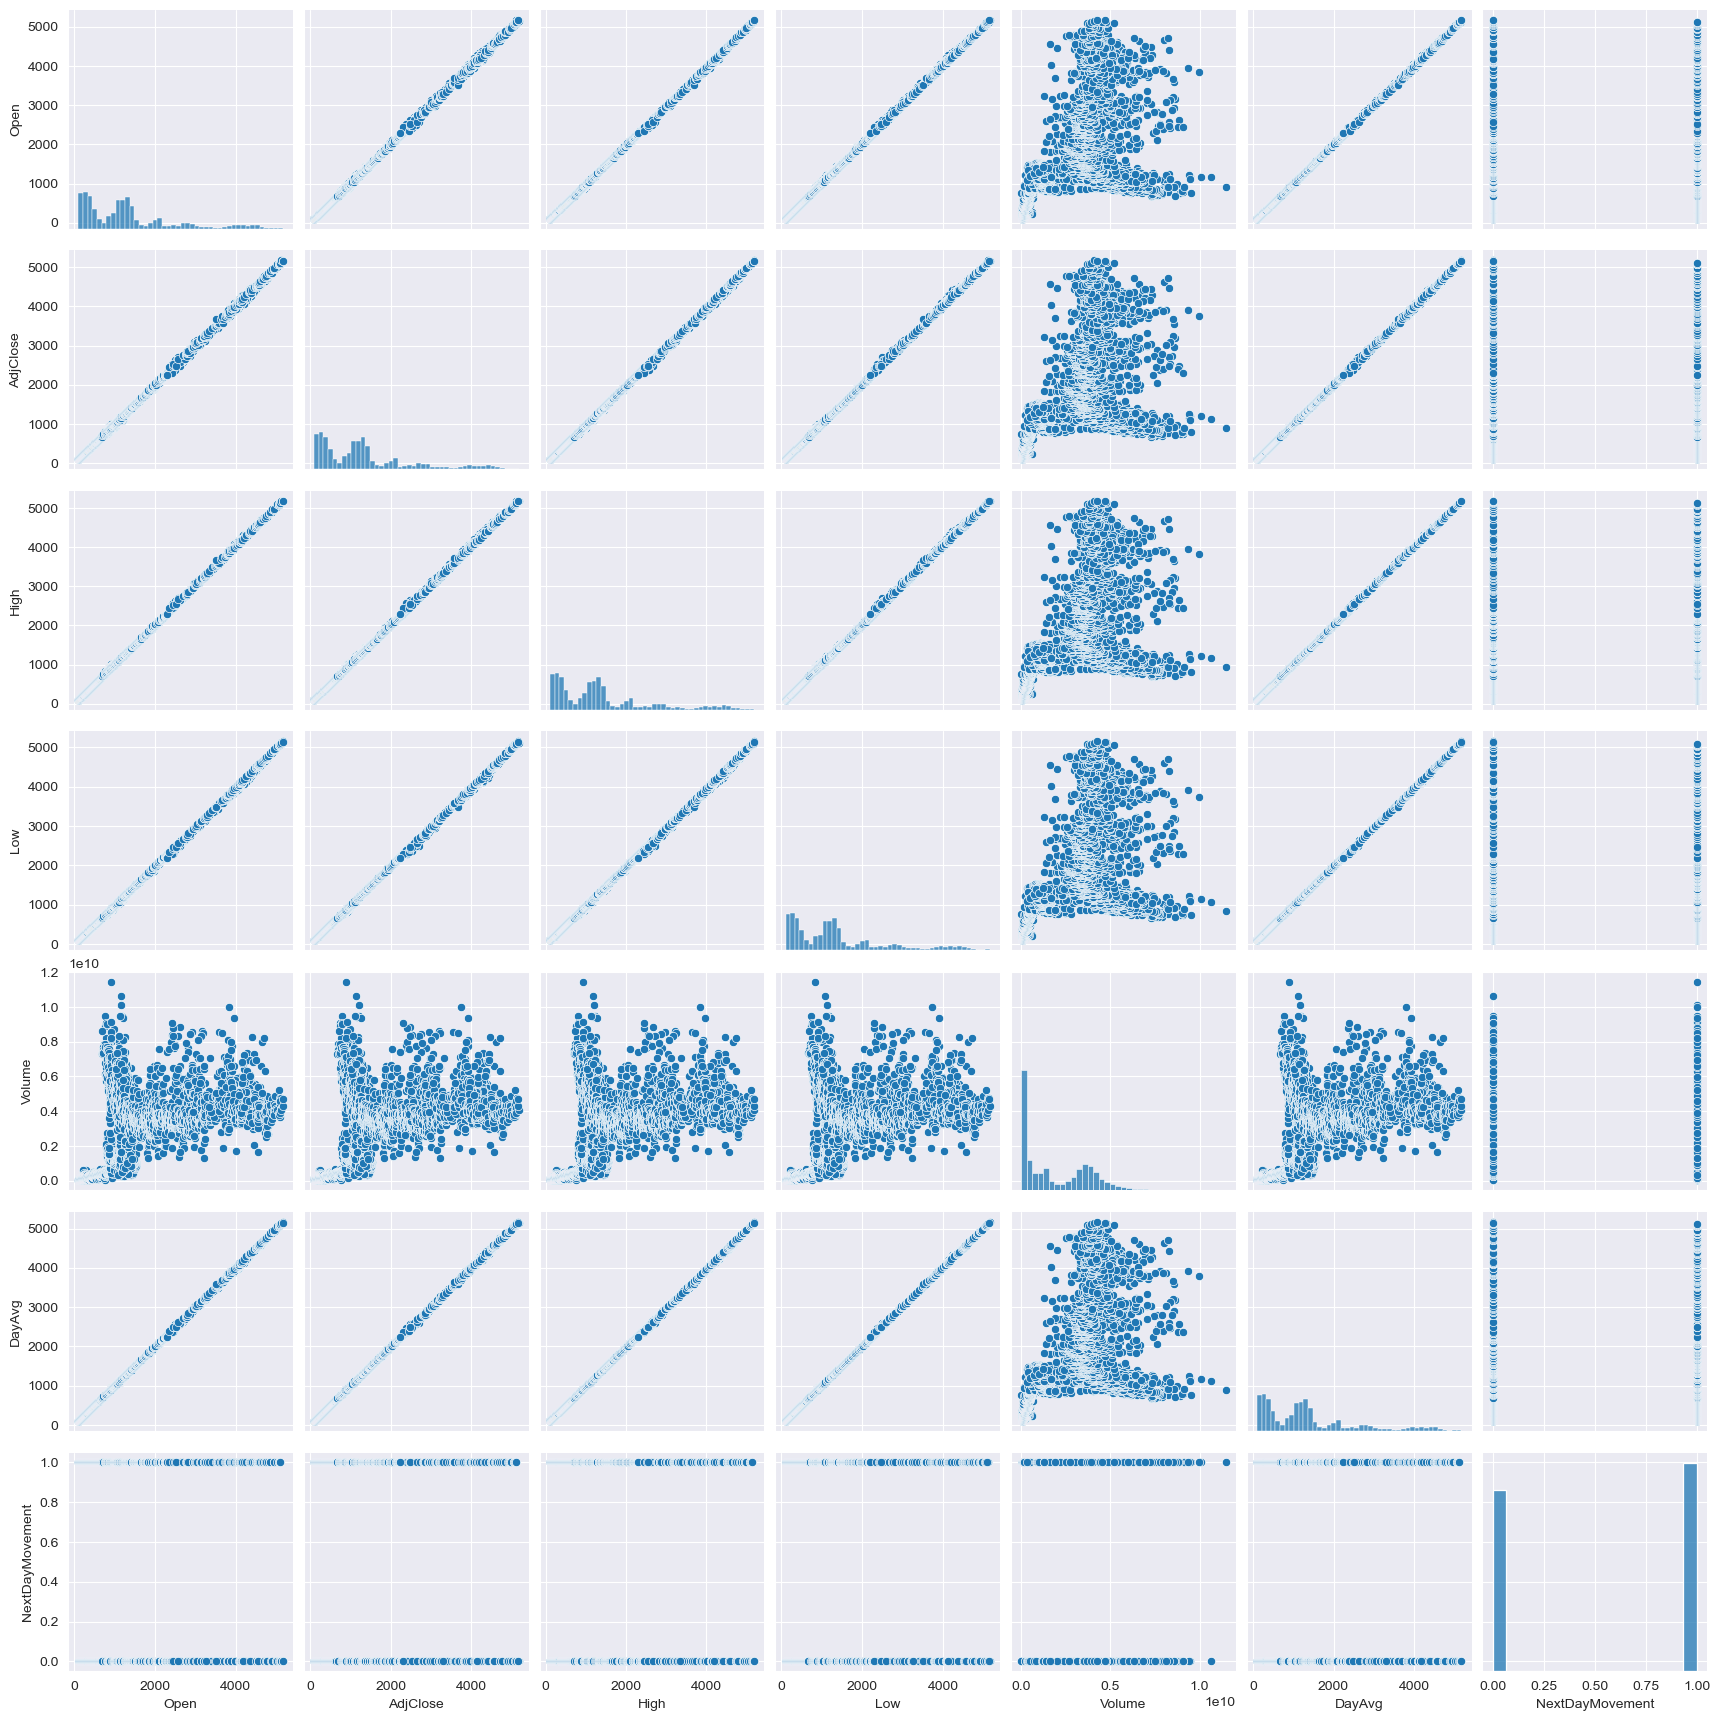

In [102]:
pairplot_vars = ['Open',  'AdjClose', 'High', 'Low', 'Volume', 'DayAvg', 'NextDayMovement']
sns.pairplot(SPX_historical, vars=pairplot_vars)

C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\rmcne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

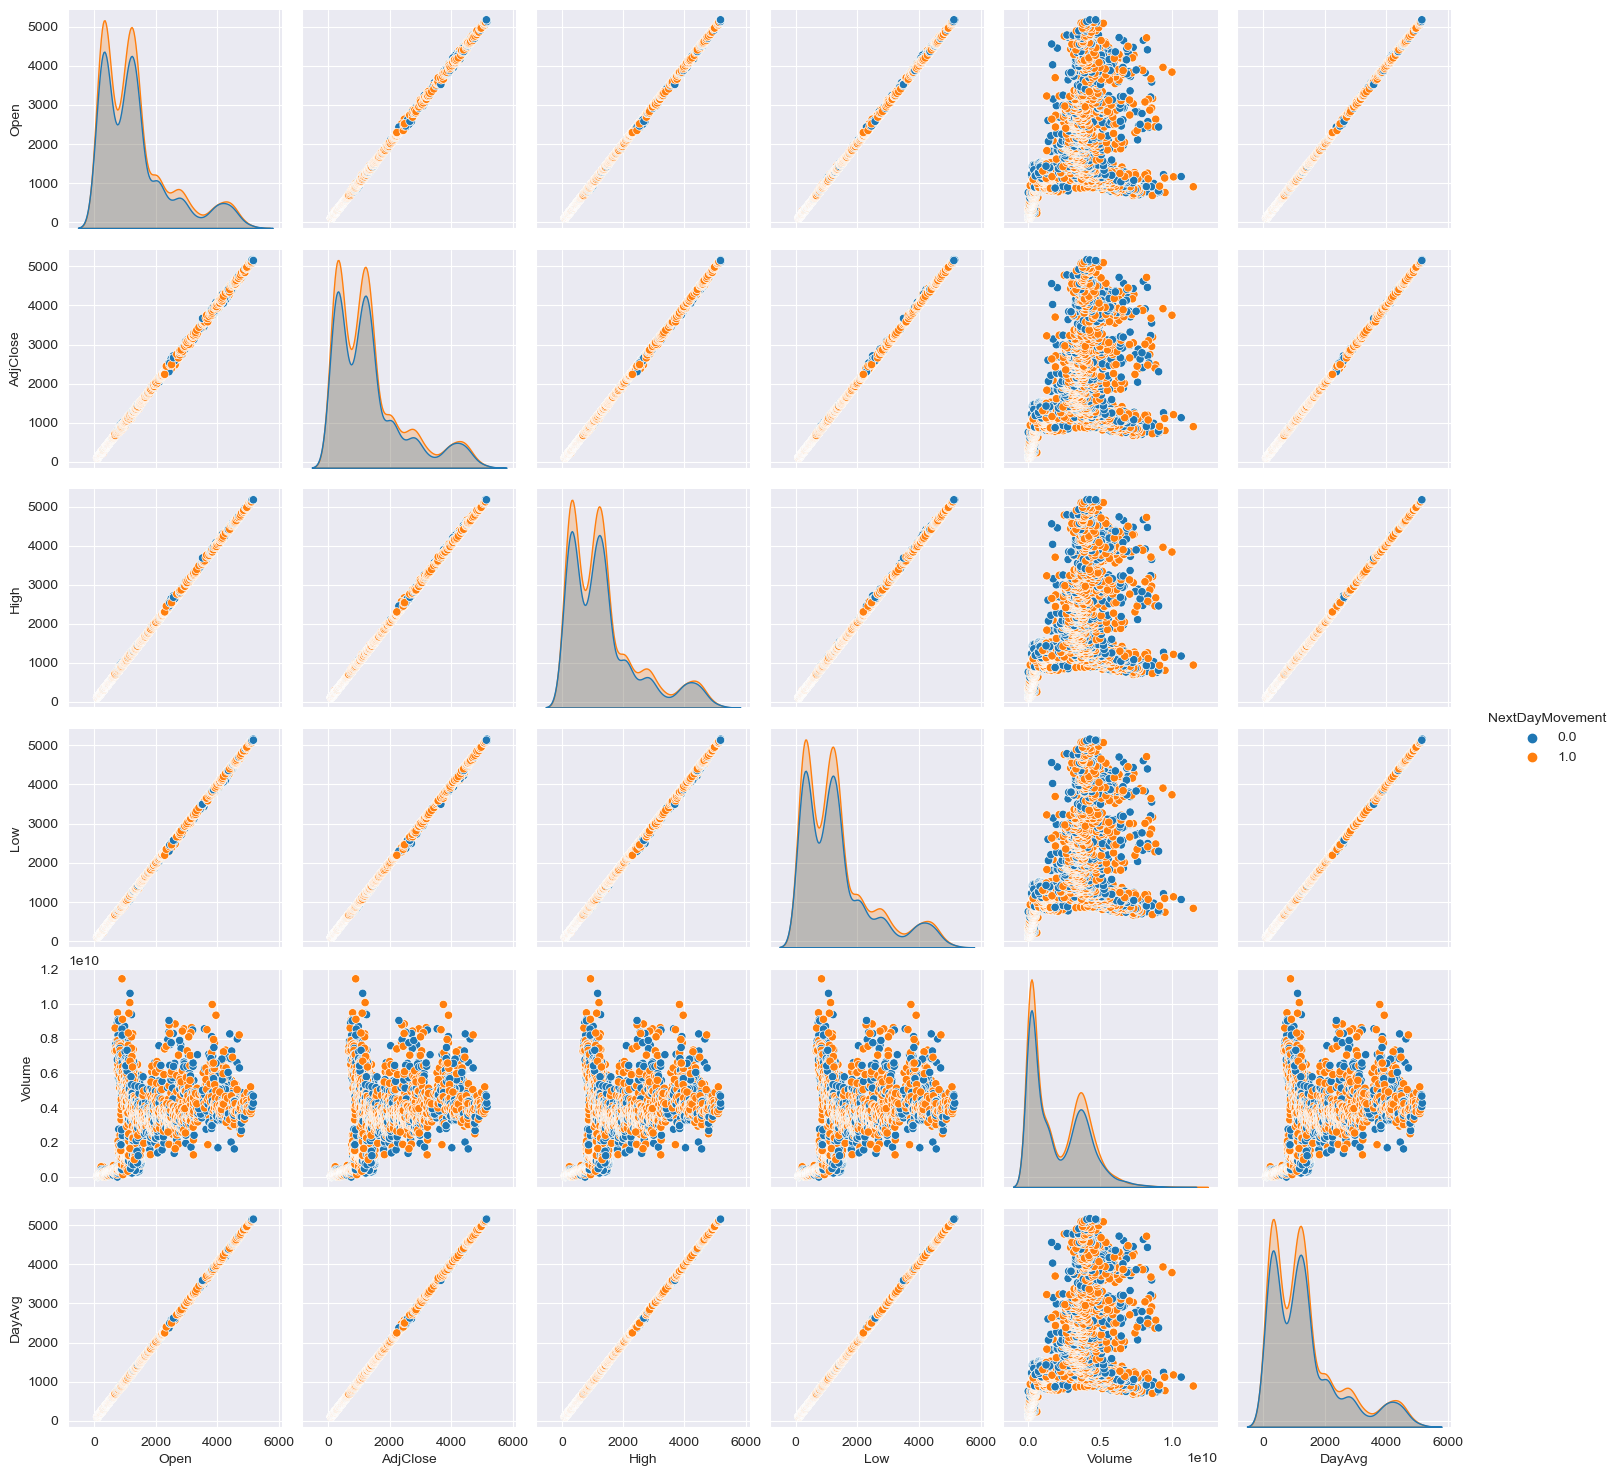

In [105]:
pairplot_vars = ['Open',  'AdjClose', 'High', 'Low', 'Volume', 'DayAvg']
sns.pairplot(SPX_historical, vars=pairplot_vars, hue='NextDayMovement')

# Dimensionality Reduction

I experiment with dimensionality reduction, just to explore the data. However, I do not believe I will use reduced data for my final models for the following reasons:
1. This is a very difficult prediction task and I suspect that the signal-to-noise ratio will be low. I believe I cannot afford to train on data which only captures a percentage of the variance in the original data.
2. PCA may fail to capture non-linear trends in the data, which I suspect there may be.
3. If I autoencode with a NN (which *could* capture non-linearity), I will do so with layers in any final NN prediction model.